# FEATURE SELECTION 

Los datos de entrada irrelevantes dificultan el entrenamiento y pueden perjudicar con la introducción de ruido. 

**BASURA EN LA ENTRADA → BASURA EN LA SALIDA**

Además, reduciendo variables evitamos overfittinng

*Rule of thumb*:  

$\text{Nº de variables} = 5 \times \log(N)$

Ejemplo: Dataset con 1000 observaciones: $5 \times \log(1000) = 5 \times 3 = 15$


## TIPOS 

### 1. No supervisado
No utilizan (o no tienen acceso) a la variable objetivo. Suelen tener
el objetivo de eliminar variables redundantes mediante correlación u otro tipo de
técnica. 

In [1]:
# Generamos datos dummy
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(random_state=2)
x_data_generated.shape

(100, 20)

**Correlaciones**: Si dos o más variables tienen una correlación muy alta la información que
aportan es redundante y queremos evitar eso por lo que normalmente nos
quedaremos con una única variable de esas.

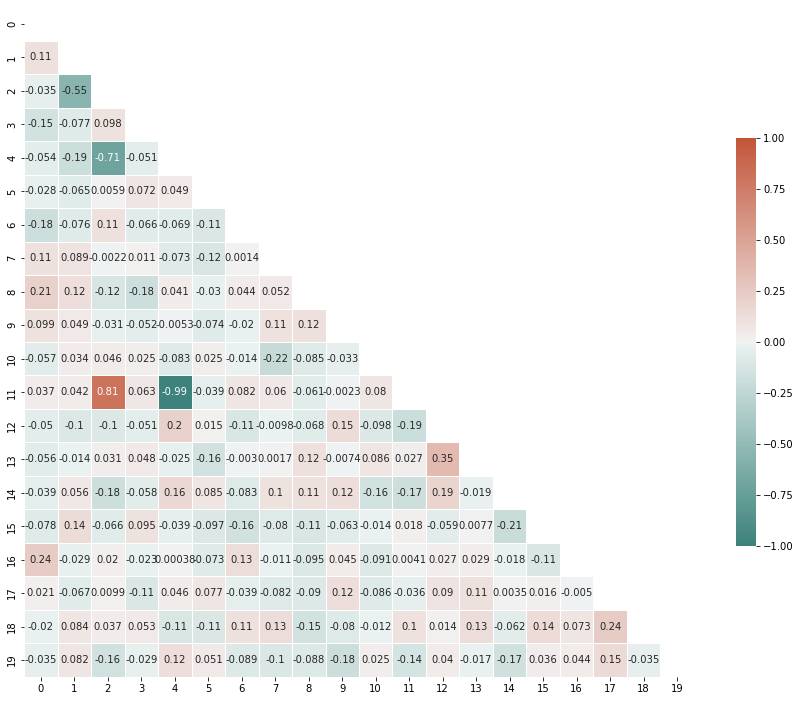

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

correlation = pd.DataFrame(x_data_generated).corr()

mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

**Filtro de varianza**: Si nuestras variables de entrada tienen una varianza baja significa
que los valores son "parecidos" por lo que seguramente nos aportarán poca
información y podremos filtrar las columnas que menos varianza tengan

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [10]:
from sklearn.feature_selection import VarianceThreshold
VarianceThreshold(0.7).fit_transform(x_data_generated).shape

(100, 20)

In [11]:
from sklearn.feature_selection import VarianceThreshold
VarianceThreshold(0.8).fit_transform(x_data_generated).shape

(100, 15)

In [12]:
from sklearn.feature_selection import VarianceThreshold
VarianceThreshold(0.9).fit_transform(x_data_generated).shape

(100, 14)

### 2. Supervisado
Buscamos las variables que tengan una mayor relación con la variable objetivo.

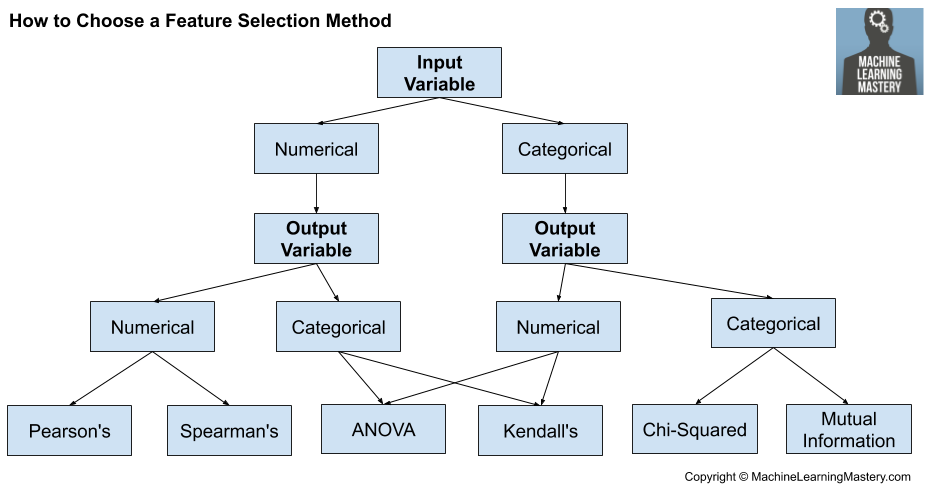

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated,y_data_generated)
x_data_kbest.shape

(100, 5)

In [15]:
x_data_varth = VarianceThreshold(0.9).fit_transform(x_data_generated)
x_data_varth.shape

(100, 14)

In [16]:
# Comparamos el desempeño de ambos datasets usando una regresión logística
logit = LogisticRegression(random_state=17)

In [19]:
cross_val_score(logit,
               x_data_generated,
               y_data_generated,
               scoring = 'roc_auc',
               cv = 5
              ).mean()

0.9240000000000002

In [20]:
cross_val_score(logit,
               x_data_kbest,
               y_data_generated,
               scoring = 'roc_auc',
               cv = 5
              ).mean()

0.9339999999999999

In [21]:
cross_val_score(logit,
               x_data_varth,
               y_data_generated,
               scoring = 'roc_auc',
               cv = 5
              ).mean()

0.9219999999999999

**Intrínseco**:
Hay algoritmos que utilizan únicamente las variables que mejoran la precisión de sus predicciones por lo que la selección de variables la realizan de manera interna. Ejemplos de esto podrían ser Lasso Regression o los arboles de decisión

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

In [29]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

rf = RandomForestClassifier(n_estimators=100, random_state=17)

# Aplicamos la regresión logística usando el feature importance del random forest
# Por defecto calcula la media del feature importance y elige las que sean superiores a esa media

pipe = make_pipeline(SelectFromModel(estimator=rf), # selección de features
                     logit
                    )

print('Reg.Log.', cross_val_score(logit, x_data_generated, y_data_generated,
                                 scoring='roc_auc',cv=5).mean())

print('Random Forest', cross_val_score(rf, x_data_generated, y_data_generated,
                                 scoring='roc_auc',cv=5).mean())

print('Reg.Log. con selección de RF', cross_val_score(pipe,x_data_generated,y_data_generated,
                                 scoring='roc_auc',cv=5).mean())

Reg.Log. 0.9240000000000002
Random Forest 0.9620000000000001
Reg.Log. con selección de RF 0.9339999999999999


**Wrapper**: Creamos diferentes subconjuntos de variables, evaluamos el comportamiento de cada uno de los subconjuntos y nos quedamos con el subconjunto de variables que mejor resultado haya dado. El problema de este tipo de técnicas es que suelen ser
computacionalmente costosas.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

RFE (*Recursive Feature Elimination*) es un algoritmo de tipo wrapper. Un algoritmo de ML ordena las variables por importancia, descarta las menos importantes y reajusta el modelo. Este proceso se repite hasta conservar un número determinado de variables

In [31]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

svc = SVC(kernel='linear')

rfe = RFE(estimator=svc,
         n_features_to_select=5)

print('RFE',cross_val_score(rfe, x_data_generated,y_data_generated,
                           scoring='roc_auc',cv=5).mean())

RFE 0.9480000000000001
